In [377]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.linear_model import LogisticRegression
pd.options.display.float_format = '{:.3f}'.format

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import plot_importance

# !pip install fast_ml
from fast_ml.feature_engineering import FeatureEngineering_DateTime

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 300)

Загружаем данные, сразу парсим колонки с датами.

In [378]:
df_row = pd.read_excel('test_task_dataset_created_20210611.xlsx',
                       sheet_name='Sheet1',
                       parse_dates=['crdeal_deallife__first_loan_open_date',
                                    'crdeal_deallife__last_loan_open_date',
                                    'crdeal_deallife__first_loan_open_date__donor_bnk',
                                   'crdeal_deallife__last_loan_open_date__donor_bnk'])

In [379]:
df_row.head().T

,0,1,2,3,4
target_flag,good,good,good,good,good
crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah,40.000,72.000,77.000,6.000,8.000
crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_not_uah,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__dldonor_bnk,4.000,2.000,4.000,1.000,5.000
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_7_days,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_30_days,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_45_days,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_60_days,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_90_days,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_120_days,0.000,0.000,0.000,0.000,0.000


# Preprocessing the data

## Размечаем колонку с таргетом в числа

In [380]:
conditions = [
    (df_row['target_flag'] == 'good'),
    (df_row['target_flag'] == 'bad')]
choices = [0, 1]
df_row['target_flag'] =  np.select(conditions, choices, default=2)

In [381]:
df_row = df_row.convert_dtypes()

In [382]:
df_row.describe().T.sort_values(by='max')

,count,mean,std,min,25%,50%,75%,max
crdeal_deallife__loans_cnt__state_sold__opened_lteq_7_days,35217.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_60_days,35217.000,0.000,0.015,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_120_days,35217.000,0.000,0.021,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_180_days,35217.000,0.001,0.027,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_360_days,35217.000,0.001,0.035,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_45_days,35217.000,0.000,0.008,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__last_active_lteq_7_days,35217.000,0.000,0.009,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__last_active_lteq_30_days,35217.000,0.001,0.026,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_30_days,35217.000,0.000,0.008,0.000,0.000,0.000,0.000,1.000
crdeal_deallife__loans_cnt__state_discounted__opened_lteq_7_days,35217.000,0.000,0.005,0.000,0.000,0.000,0.000,1.000


Удаляем колонку "crdeal_deallife__loans_cnt__state_sold__opened_lteq_7_days", т.к. в ней все значения = 0

In [383]:
df_row.drop(columns='crdeal_deallife__loans_cnt__state_sold__opened_lteq_7_days', inplace=True)

## Делим датасет на трэйн/тест

In [384]:
df_train = df_row[df_row.target_flag < 2]
print('Train', df_train.shape)
df_test = df_row[df_row.target_flag == 2]
print('Test', df_test.shape)
df_test_withnan = df_test.copy()

Train (31625, 284)
Test (3686, 284)


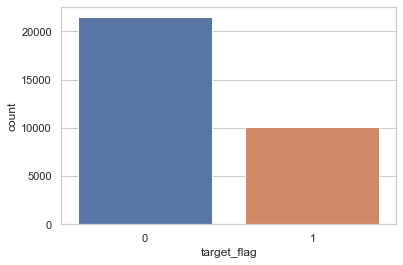

0    21485
1    10140
Name: target_flag, dtype: Int64

In [385]:
ax = sns.countplot(x = 'target_flag', data=df_train)
plt.show()

df_train['target_flag'].value_counts()

## Проверяем пропуски в цифровых даных

In [386]:
# доля пропусков в каждом предикте
df_row['num_missing'] = df_row.isnull().sum(axis = 1)/df_row.shape[1]

In [387]:
df_row.num_missing.sort_values(ascending=False).head(100)

22612   0.996
28958   0.996
35259   0.996
35064   0.996
31926   0.996
10871   0.996
12512   0.996
10539   0.996
29733   0.996
10031   0.996
22304   0.996
27266   0.996
18912   0.996
12491   0.996
15137   0.996
3263    0.996
22522   0.996
29085   0.996
5910    0.996
20666   0.996
29102   0.996
31421   0.996
20982   0.996
21349   0.996
17152   0.996
24062   0.996
3360    0.996
20925   0.996
14508   0.996
5438    0.996
4271    0.996
16137   0.996
2628    0.996
10714   0.996
32054   0.996
12026   0.996
34252   0.996
13363   0.996
22865   0.996
10748   0.996
2543    0.996
10023   0.996
2505    0.996
16973   0.996
10804   0.996
24913   0.996
22653   0.996
18209   0.996
15955   0.996
23520   0.996
21104   0.996
13138   0.996
34055   0.996
22069   0.996
26622   0.996
32868   0.996
6229    0.996
16295   0.996
425     0.996
35103   0.996
20170   0.996
4651    0.996
25305   0.996
20585   0.996
2369    0.996
24400   0.996
26431   0.996
29470   0.996
29403   0.996
17460   0.996
13779   0.996
24152 

In [388]:
df_test[df_test.crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah.isnull()].T

,6229,10453,10714,10748,11754,14508,20170,23520,31421,35084
target_flag,2,2,2,2,2,2,2,2,2,2
crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_not_uah,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_7_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_30_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_45_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_60_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_90_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_120_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [389]:
df_train[df_train.crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah.isnull()].T

,425,2369,2505,2543,2628,3181,3263,3360,4271,4500,...,30425,31926,32054,32122,32868,34055,34252,35064,35103,35259
target_flag,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_not_uah,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_7_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_30_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_45_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_60_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_90_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_120_days,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Доли строк со всеми пропущенными значениями кроме таргета.

In [390]:
df_train[df_train.count(axis=1) == 1].shape[0]/df_train.shape[0] * 100

0.2656126482213439

In [391]:
df_test[df_test.count(axis=1) == 1].shape[0]/df_test.shape[0] * 100

0.27129679869777534

Убираем строки с пропусками во всех колонках кроме таргета, т.к. заполнить их объективно нет возможности.

In [392]:
df_train.dropna(subset=['crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah'], inplace=True)
df_test.dropna(subset=['crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah'], inplace=True)

По хорошему надо понимать что именно это за данные (колокни) и попытаться заполнить пропуски. Способы есть разные и их применеие зависит от понимания самих данных.
Подозреваю, что в данном датасете их убрали специально.

## Проверяем дубликаты

In [393]:
if df_train[df_train.duplicated()].shape[0] + df_test[df_test.duplicated()].shape[0] == 0:
    print('ура!')

ура!


In [394]:
# сохраним данные для быстрой загрузки уже почищенных данных  
df_train.to_parquet('train.pq', compression='gzip')
df_test.to_parquet('test.pq', compression='gzip')

In [395]:
# df_train = pd.read_parquet('train.pq')
# df_test = pd.read_parquet('test.pq')

Переходим к оставшимся пропущенным данным.

In [396]:
df_train.isnull().mean().round(4).mul(100).sort_values(ascending=False)

crdeal_deallife__current_max_dpd__donor_bnk                                           13.660
crdeal_deallife__current_max_dpd__donor_mfo                                           10.530
crdeal_deallife__initial_amount_sum__state_clsd                                        6.090
crdeal_deallife__initial_amount_min__state_clsd                                        6.090
crdeal_deallife__historical_max_overdue_debt__clsd_state                               6.090
crdeal_deallife__initial_amount_max__state_clsd                                        6.090
crdeal_deallife__initial_amount_mean__state_clsd                                       6.090
crdeal_deallife__plan_debt_max__donor_bnk                                              5.320
crdeal_deallife__last_loan_status__donor_bnk                                           5.320
crdeal_deallife__initial_amount_sum__donor_bnk                                         5.320
crdeal_deallife__first_loan_status__donor_bnk                         

In [397]:
df_test.isnull().mean().round(4).mul(100).sort_values(ascending=False)

crdeal_deallife__current_max_dpd__donor_bnk                                           11.240
crdeal_deallife__current_max_dpd__donor_mfo                                            6.370
crdeal_deallife__historical_max_overdue_debt__clsd_state                               5.470
crdeal_deallife__initial_amount_sum__state_clsd                                        5.470
crdeal_deallife__initial_amount_min__state_clsd                                        5.470
crdeal_deallife__initial_amount_max__state_clsd                                        5.470
crdeal_deallife__initial_amount_mean__state_clsd                                       5.470
crdeal_deallife__plan_debt_sum__donor_bnk                                              4.730
crdeal_deallife__first_loan_open_date__donor_bnk                                       4.730
crdeal_deallife__last_loan_open_date__donor_bnk                                        4.730
crdeal_deallife__last_loan_status__donor_bnk                          

В данном случае поступим макисмально просто, заменив все пропущенные цифровые данные медианой. Если бы было "понимание" расшифровки колонок, можно было бы "побороться".

In [398]:
numeric_train = df_train.select_dtypes('number').columns
df_train[numeric_train] = df_train[numeric_train].fillna(df_train[numeric_train].median())
numeric_test = df_test.select_dtypes('number').columns
df_test[numeric_test] = df_test[numeric_test].fillna(df_test[numeric_test].median())

## Пропуски во временных данных.

In [399]:
df_train.describe(include = 'datetime').T

,count,unique,top,freq,first,last
crdeal_deallife__first_loan_open_date,31541,4836,2011-08-29,82,2000-08-27,2022-07-06
crdeal_deallife__last_loan_open_date,31541,4836,2011-08-29,82,2000-08-27,2022-07-06
crdeal_deallife__first_loan_open_date__donor_mfo,30070,2650,2019-11-27,122,2000-08-27,2020-09-13
crdeal_deallife__last_loan_open_date__donor_mfo,30070,2650,2019-11-27,122,2000-08-27,2020-09-13
crdeal_deallife__first_loan_open_date__donor_bnk,29866,4646,2011-08-29,82,2003-01-09,2022-07-06
crdeal_deallife__last_loan_open_date__donor_bnk,29866,4646,2011-08-29,82,2003-01-09,2022-07-06


Заполняем пропуски самой часто встречающейся датой столбца (совсем не уверен, что это корректно, но опять же нет понимания данных)

In [400]:
df_train.fillna(df_train.select_dtypes(include='datetime').mode().iloc[0], inplace=True)
df_test.fillna(df_test.select_dtypes(include='datetime').mode().iloc[0], inplace=True)

# Feature engeneering

## Feature engeneering для datetime данных

In [401]:
list_dates = list(df_train.select_dtypes(include='datetime').columns)

In [402]:
dt_fe = FeatureEngineering_DateTime(drop_orig=True)
for i in list_dates:
    dt_fe.fit(df_train, datetime_variables=[i], prefix = f'{i}:')
    df_train = dt_fe.transform(df_train)
dt_fe_test = FeatureEngineering_DateTime(drop_orig=True)
for j in list_dates:
    dt_fe_test.fit(df_test, datetime_variables=[j], prefix = f'{j}:')
    df_test = dt_fe_test.transform(df_test)

Уберем колонки с 0 значениями

In [403]:
d = ['day_part',
     'second',
     'minute',
     'hour',
     'time']

In [404]:
for i in d:
    df_train.drop(columns = df_train.filter(like=i, axis=1).columns, inplace=True)
    df_test.drop(columns = df_test.filter(like=i, axis=1).columns, inplace=True)


Оцифровываем булиевые значения

In [405]:
df_train.replace({False: 0, True: 1}, inplace=True)
df_test.replace({False: 0, True: 1}, inplace=True)

## Удаляем один из двух цифровых мультиколлинеарных предиктов.

In [406]:
corr_matrix = df_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

to_drop

['crdeal_deallife__loans_cnt__dldonor_bnk__last_active_lteq_60_days',
 'crdeal_deallife__loans_cnt__dldonor_bnk__last_active_lteq_90_days',
 'crdeal_deallife__loans_cnt__dldonor_bnk__last_active_lteq_180_days',
 'crdeal_deallife__loans_cnt__dldonor_bnk__last_active_lteq_360_days',
 'crdeal_deallife__loans_cnt__dldonor_bnk__last_active_gt_360_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo',
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_45_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_60_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_90_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_120_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_180_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__last_active_lteq_45_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__last_active_lteq_60_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__last_active_lteq_90_days',
 'crdeal_deallife__loans_cnt__dldonor_mfo__last_active_lteq_120_days

In [407]:
df_train.drop(columns = to_drop, inplace = True)
df_train.shape

(31541, 216)

In [408]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31541 entries, 0 to 35310
Columns: 216 entries, target_flag to crdeal_deallife__first_loan_open_date__donor_bnk:is_weekend
dtypes: Float64(46), Int32(1), Int64(137), int32(3), int64(29)
memory usage: 57.3 MB


"Выравниваем" трэйн/тест

In [409]:
columns_to_train = df_train.columns

In [410]:
df_test = df_test[columns_to_train]

In [411]:
df_test.drop('target_flag', axis=1, inplace=True)

# Строим модели

In [412]:
X = df_train.drop(columns = 'target_flag')
y = df_train['target_flag']

X_train, X_val, Y_train, Y_val = train_test_split( X, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = df_train['target_flag'])
print(f'training set = {X_train.shape[0]} строк, validation set= {X_val.shape[0]} строк')

training set = 25232 строк, validation set= 6309 строк


In [413]:
feature_names = X_train.columns

Нормализация

In [414]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
df_test = scaler.fit_transform(df_test)
Y_train = Y_train.astype('int')
Y_val = Y_val.astype('int')

## Logistic Regression model 

In [415]:
LR = LogisticRegression().fit(X_train, Y_train)

LR_pred_train = LR.predict(X_train)
LR_pred_val = LR.predict(X_val)

print(classification_report(LR_pred_val, Y_val))

              precision    recall  f1-score   support

           0       0.95      0.70      0.80      5818
           1       0.13      0.53      0.21       491

    accuracy                           0.68      6309
   macro avg       0.54      0.62      0.51      6309
weighted avg       0.88      0.68      0.76      6309



In [416]:
print(classification_report(LR_pred_train, Y_train))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81     23369
           1       0.13      0.55      0.21      1863

    accuracy                           0.69     25232
   macro avg       0.54      0.62      0.51     25232
weighted avg       0.89      0.69      0.76     25232



In [417]:
roc_auc_score(Y_val, LR_pred_val)

0.5380786851976059

## XGBoost

In [418]:
dtrain = xgb.DMatrix(X_train, Y_train, feature_names = feature_names)
dval = xgb.DMatrix(X_val, Y_val, feature_names = feature_names)

In [419]:
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.10,
    "eta": 0.1,
    "eval_metric": ["logloss", "auc"],
    
}

num_rounds = 150

In [420]:
watchlist = [(dval, "validation"), (dtrain, "train")]

In [421]:
xgb_model = xgb.train(params,
                      dtrain,
                      num_rounds,
                      watchlist,
#                       early_stopping_rounds=2,
                      )

[0]	validation-logloss:0.67564	validation-auc:0.63272	train-logloss:0.67702	train-auc:0.62883
[1]	validation-logloss:0.66150	validation-auc:0.63816	train-logloss:0.66380	train-auc:0.63781
[2]	validation-logloss:0.65001	validation-auc:0.63904	train-logloss:0.65281	train-auc:0.64385
[3]	validation-logloss:0.64092	validation-auc:0.64463	train-logloss:0.64360	train-auc:0.64988
[4]	validation-logloss:0.63339	validation-auc:0.64688	train-logloss:0.63597	train-auc:0.65251
[5]	validation-logloss:0.62688	validation-auc:0.64691	train-logloss:0.62960	train-auc:0.65303
[6]	validation-logloss:0.62173	validation-auc:0.65020	train-logloss:0.62421	train-auc:0.65476
[7]	validation-logloss:0.61718	validation-auc:0.65311	train-logloss:0.61930	train-auc:0.65927
[8]	validation-logloss:0.61339	validation-auc:0.65441	train-logloss:0.61537	train-auc:0.66043
[9]	validation-logloss:0.61014	validation-auc:0.65585	train-logloss:0.61185	train-auc:0.66221
[10]	validation-logloss:0.60707	validation-auc:0.65752	train

[87]	validation-logloss:0.58214	validation-auc:0.68074	train-logloss:0.56694	train-auc:0.71380
[88]	validation-logloss:0.58200	validation-auc:0.68087	train-logloss:0.56659	train-auc:0.71411
[89]	validation-logloss:0.58208	validation-auc:0.68059	train-logloss:0.56631	train-auc:0.71437
[90]	validation-logloss:0.58201	validation-auc:0.68080	train-logloss:0.56603	train-auc:0.71493
[91]	validation-logloss:0.58201	validation-auc:0.68073	train-logloss:0.56584	train-auc:0.71525
[92]	validation-logloss:0.58201	validation-auc:0.68073	train-logloss:0.56556	train-auc:0.71578
[93]	validation-logloss:0.58171	validation-auc:0.68122	train-logloss:0.56524	train-auc:0.71629
[94]	validation-logloss:0.58170	validation-auc:0.68117	train-logloss:0.56500	train-auc:0.71664
[95]	validation-logloss:0.58165	validation-auc:0.68124	train-logloss:0.56481	train-auc:0.71708
[96]	validation-logloss:0.58162	validation-auc:0.68136	train-logloss:0.56461	train-auc:0.71743
[97]	validation-logloss:0.58169	validation-auc:0.6

### результаты

In [422]:
preds_prob = xgb_model.predict(dval)

In [423]:
# predicted_labels = preds_prob > 0.5
print("Roc-auc на валидационной выборке: {}".format(
    round(roc_auc_score(Y_val, preds_prob), 3)))

Roc-auc на валидационной выборке: 0.683


In [424]:
preds_xgb = np.where(preds_prob > 0.5, 1, 0)

In [425]:
print(classification_report(preds_xgb, Y_val))

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      5601
           1       0.20      0.57      0.29       708

    accuracy                           0.69      6309
   macro avg       0.56      0.64      0.55      6309
weighted avg       0.85      0.69      0.75      6309



__Что в целом лучше, чем дала logistic regression но можно еще потюнинговать параметры.__


__Хотя лучше поиграться с фичами (очень долго).__

### Важность предикторов

In [426]:
importances = xgb_model.get_fscore()
importances

{'crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_uah': 4.0,
 'crdeal_deallife__loans_cnt__dlrolesub_zaemshik__curr_not_uah': 4.0,
 'crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_60_days': 4.0,
 'crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_180_days': 6.0,
 'crdeal_deallife__loans_cnt__dldonor_bnk__opened_lteq_360_days': 6.0,
 'crdeal_deallife__loans_cnt__dldonor_bnk__opened_gt_360_days': 7.0,
 'crdeal_deallife__loans_cnt__dldonor_bnk__last_active_lteq_45_days': 1.0,
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_7_days': 1.0,
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_30_days': 9.0,
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_lteq_360_days': 22.0,
 'crdeal_deallife__loans_cnt__dldonor_mfo__opened_gt_360_days': 2.0,
 'crdeal_deallife__loans_cnt__dldonor_mfo__last_active_lteq_7_days': 2.0,
 'crdeal_deallife__loans_cnt__dldonor_mfo__last_active_lteq_30_days': 5.0,
 'crdeal_deallife__loans_cnt__state_exst': 19.0,
 'crdeal_deallife__loans_cnt__

15 самых важных предикторов

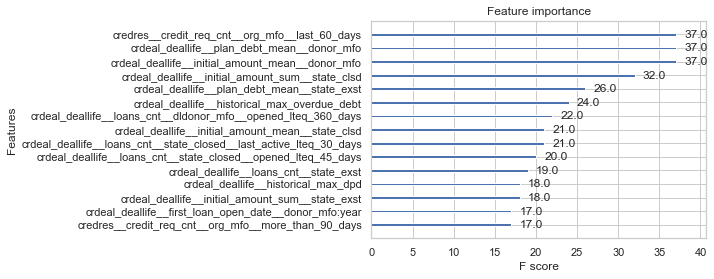

In [427]:
plot_importance(xgb_model, max_num_features=15)
plt.show()